In [227]:
import os
import pandas as pd
import numpy as np
import quantstats as qs
from typing import Dict
import datetime as dt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

In [136]:
class ReportManager():
    def __init__(self,report_dir = "reports"):
        self.report_dir = report_dir
        os.makedirs(report_dir, exist_ok = True)
        self.reset()
        
    def reset(self):
        self.lines = []
        self.running_pnl = []
        self.timestamps = []

    def log_header(self,date):
        self.lines.append("===================================================================")
        self.lines.append(f" Report for {date}")
        self.lines.append("===================================================================")
        self.lines.append(f"{'Time':<12} | {'Action':<20} | {"SID": <5} | {'SPREAD':<10} | {'Type':<4} |{"LEG1:SOLD":<7} | {"LEG2:Bought":<7} | {'Running PnL':<10}")
        self.lines.append("-"*100)

    def log_trade(self,time,action,sid,spread,opt_type,Sold_strike,Bought_strike,running_pnl):
        time_str = time.strftime("%H:%M:%S") if hasattr(time, "strftime") else str(time)
        self.lines.append(f"\n{time_str:<12} | {action:<25} | {sid:5} |{spread:<10} | {opt_type:<4} | {Sold_strike:<7.2f} | {Bought_strike:<7.2f} | {running_pnl:<10.2f}")
        self.running_pnl.append(running_pnl)
        self.timestamps.append(time)

    def log_event(self, time, event):
        time_str = time.strftime("%H:%M:%S") if hasattr(time, "strftime") else str(time)
        self.lines.append(f"{time_str:<12} | {event}")

    def save_report(self, date, df , timeframe ,straddle_series, Day_high, Day_low):
        file_path = os.path.join(self.report_dir, f"{date}.txt")
        with open(file_path, "w") as f:
            f.write("\n".join(self.lines))
        self.df = df
        self.timeframe = timeframe

        
        self.df = self.df.resample(timeframe,
                                origin = "start",
                                offset = "0min").agg({"undLtp": ["first","max","min","last"]})
        self.df.columns = ["Open","High","Low","Close"]


        fig = go.Figure()
        fig = make_subplots(specs=[[{"secondary_y": True}]])
        fig.add_hline(y = Day_high)
        fig.add_hline(y = Day_low)
        fig.add_trace(go.Ohlc(x = self.df.index , open = self.df["Open"]
                               ,high = self.df["High"] , low = self.df['Low'],
                               close = self.df["Close"]), secondary_y=False)

        
        straddle_line = straddle_series.resample("1min").mean().reindex(self.df.index,method= "ffill")
        fig.add_trace(go.Scatter(x = self.df.index,y = straddle_line,mode="lines",line=dict(color="blue", width=1)), secondary_y=True)
        chart_folder = r"D:\Python\pythonproject\US market\Us-market\Strategy--with logs\charts"
        chart_path = os.path.join(chart_folder, f"{date}_chart.png")
        pio.write_image(fig,chart_path,width = 1200, height= 700, scale = 2)
        # fig.write_html(os.path.join(self.report_dir, f"{date}_chart.html"))

        with open(file_path, "a") as f:
            f.write(f"\nChart saved as: {chart_path}\n")


    

In [262]:
############ PARAMETERS #################
class Params():
    def __init__(self) -> None:
        self.period = "30mins"
        self.strike_chng = 5
        self.lot_size = 100
        self.ref_atm = 0
        self.ref_time = 0
        self.date = ""
        self.period_high = 0
        self.period_low = 0
        self.start_ORB_tm = dt.time(9,31)
        self.end_ORB_tm = dt.time(10)
        self.entry_tm = dt.time(9,31,30)
        self.max_pos = 0
        self.net_credit = 0
        self.sid = 1
        self.enter_Trade = False
        self.re_entry = False
        self.base_straddle = 0
        self.ref_callsell_strike = 0
        self.ref_putsell_strike = 0
        self.square_off_time = dt.time(15,45)
        self.spread_dst = 5
        self.condor_spread_dst = 10
        self.realised_pnl = 0
        self.unrealised_pnl = 0
        self.total_pnl = 0
        self.threshold = 0
        self.abort_strategy = 0
        self.add_putspread_count = 0
        self.add_callspread_count = 0
        self.spread_entry_tm = None
        self.spread_side = ""
        self.call_list = 0
        self.put_list = 0
        self.no_of_lots = 0
        self.group_stoploss = -2000
        self.max_m2m = 0
        self.max_calls = 0
        self.max_puts = 0 
        self.last_trade_was = None
        self.consecutive_count = 0
        self.last_call_time = None
        self.last_put_time = None
        self.last_trade_time = None

class Single_leg():
    def __init__(self):
        self.strike = 0
        self.bs = 0
        self.status = 0
        self.open_px = 0
        self.close_px = 0
        self.open_time = 0
        self.close_time = 0
        self.lots = 0
        self.m2m = 0
        self.opt_type = ""
        self.max_m2m = 0
        self.max_loss = 0
        self.sold_point = 0
        self.low = 0
        self.high = 0
        self.sell_type = ""
        self.trail_sl = 0
        self.trail_steps = 0
        self.trade_remark = ""
        self.trade_zone = ""
        self.validated = False
        self.validation_checked = False
        self.entry_RRP = 0
        self.abort_trade = 1

class Vertical_spread():
    def __init__(self) -> None:
        
        self.status = 0
        self.atm_strike = 0
        self.opt_type = ""
        self.sell_leg = Single_leg()
        self.buy_leg = Single_leg() 
        self.spread_status = 0
        self.max_loss = 0
        self.max_profit = 0
        self.net_credit = 0
        self.target = 0
        self.stoploss = 0
        

class Condor():
    def __init__(self) -> None:
        self.atm_strike = 0
        self.status = 0
        self.max_profit = 0
        self.opt_type = ""
        self.call_spread = Vertical_spread()
        self.put_spread = Vertical_spread()
        

class Position():
    def __init__(self) -> None:
        self.open_time = None
        self.sid = 0
        self.main_leg = Single_leg()
        self.hedge_leg = Single_leg()
        
def check_orb_breakout(ohlc_df,orb_high,orb_low,end_orb_time,square_off_time):

    for i in range(len(ohlc_df) - 2):
        curr_time = ohlc_df.index[i].time()

        if curr_time > end_orb_time and curr_time < square_off_time:
            close = ohlc_df.iloc[i]['Close']
            next_close = ohlc_df.iloc[i+1]['Close']
            entry_time = ohlc_df.index[i+2].time() 

            if close > (orb_high + 2)  and next_close > (orb_high + 2):
                return True, "PUT", entry_time
            

            elif close < (orb_low - 2) and next_close < (orb_low - 2 ):
                return True, 'CALL', entry_time
            
    return False, None , None

def calculate_values(row):
    ce_col = f"C_{int(row["atm_strike"])}_price"
    pe_col = f"P_{int(row["atm_strike"])}_price"

    ce_value = row[ce_col]
    pe_value = row[pe_col]

    straddle_px = ce_value + pe_value

    return straddle_px

class OHLC():
    def __init__(self):
        self.df = None
        self.timeframe = 0

    def making_ohlc(self,df,timeframe):
        self.df = df
        self.timeframe = timeframe

        
        self.df = self.df.resample(timeframe,
                                origin = "start",
                                offset = "0min").agg({"undLtp": ["first","max","min","last"]})
        self.df.columns = ["Open","High","Low","Close"]

        return self.df


In [270]:
def get_nearest_strike(idx, atm_strike, opt_type, target_px, strike_step=5, search_range=20):
    """
    Find strike where premium is closest to target_px.
    idx        : row of df.itertuples()
    atm_strike : rounded atm
    opt_type   : "C" or "P"
    target_px  : target premium (15 or 20)
    strike_step: difference between strikes (usually 5 for SPXW)
    search_range: how many steps to search on each side
    """
    best_strike = None
    best_diff = float("inf")

    for k in range(-search_range, search_range+1):
        strike = atm_strike + k*strike_step
        try:
            px = getattr(idx, f"{opt_type}_{strike}_bid")
        except AttributeError:
            continue

        if px is None or np.isnan(px) or px <= 0:
            continue

        diff = abs(px - target_px)
        if diff < best_diff:
            best_diff = diff
            best_strike = strike

    return best_strike
# def can_take_trade(last_trade_was, opt_type,consecutive_count):
#     # if same as last trade type
#     if last_trade_was == opt_type:
#         if consecutive_count >= 2:
#             return False   # block trade
#         else:
#             return True
#     else:
#         return True

def can_take_trade(curr_time, opt_type, last_time, min_gap=15):
    if opt_type == "C":

        if last_time is None:
            return True
        return (curr_time - last_time).total_seconds() >= min_gap * 60
    elif opt_type == "P":
        if last_time is None:
            return True
        return (curr_time - last_time).total_seconds() >= min_gap * 60
    return False

def position_exists(positions_map, opt_type, strike):
    for pos in positions_map.values():
        if pos.main_leg.status == 1 and pos.main_leg.opt_type == opt_type and pos.main_leg.strike == strike:
            return True
    return False

def mark_actions_from_alerts(df, ohlc_call_5, ohlc_put_5):
    """
    df           : main 1-second dataframe with 'undLtp' column
    ohlc_call_5  : 5-min OHLC dataframe for CALL alerts (must have RRP, High, Low)
    ohlc_put_5   : 5-min OHLC dataframe for PUT alerts (must have RRP, High, Low)

    Returns:
        df with 'action' column marked with SELL_ITM_CALL / SELL_ITM_PUT
    """

    df["action"] = "NOTHING"

    # --- Handle CALL alerts ---
    for i, row in enumerate(ohlc_call_5.itertuples()):
        # if i == 0:
        #     continue
        prev_candle = ohlc_call_5.iloc[i - 1]
        prev_rrp = prev_candle["RRP"]
        if prev_rrp <= 0.1:   # CALL alert
            alert_idx = row.Index 
            alert_low = prev_candle["Low"]

            confirm_start = alert_idx 
            confirm_end   = alert_idx + dt.timedelta(seconds = 179)

            df_confirm = df[(df.index >= confirm_start) & (df.index <= confirm_end)]
            
            if not df_confirm.empty:
                confirm_close = df_confirm["undLtp"].iloc[-1]
                if confirm_close < alert_low:
                    # mark entry at next tick
                    entry_time = confirm_end + dt.timedelta(seconds=1)
                    if entry_time in df.index:
                        df.at[entry_time, "action"] = "SELL_ITM_CALL"
                    else:
                        later_idx = df[df.index > entry_time].index.min()
                        if pd.notna(later_idx):
                            df.at[later_idx, "action"] = "SELL_ITM_CALL"

    # --- Handle PUT alerts ---
    for i, row in enumerate(ohlc_put_5.itertuples()):
        # if i == 0:
        #     continue
        prev_candle = ohlc_put_5.iloc[i - 1]
        prev_rrp = prev_candle["RRP"]
        if prev_rrp >= 0.88:   # PUT alert
            alert_idx = row.Index
            alert_high = prev_candle["High"]

            confirm_start = alert_idx 
            confirm_end   = alert_idx + dt.timedelta(seconds = 179)

            df_confirm = df[(df.index >= confirm_start) & (df.index <= confirm_end)]
            
            if not df_confirm.empty:
                confirm_close = df_confirm["undLtp"].iloc[-1]
                if confirm_close > alert_high:
                    entry_time = confirm_end + dt.timedelta(seconds=1)
                    if entry_time in df.index:
                        df.at[entry_time, "action"] = "SELL_ITM_PUT"
                    else:
                        later_idx = df[df.index > entry_time].index.min()
                        if pd.notna(later_idx):
                            df.at[later_idx, "action"] = "SELL_ITM_PUT"

    return df

In [205]:
meetings = ["30-01-2024", "31-01-2024",
 "19-03-2024", "20-03-2024",
 "30-04-2024", "01-05-2024",
 "11-06-2024", "12-06-2024",
 "30-07-2024", "31-07-2024",
 "17-09-2024", "18-09-2024",
 "06-11-2024", "07-11-2024",
 "17-12-2024", "18-12-2024",

"28-01-2025", "29-01-2025",
 "18-03-2025", "19-03-2025",
 "06-05-2025", "07-05-2025",
 "17-06-2025", "18-06-2025",
 "29-07-2025", "30-07-2025",
 "16-09-2025", "17-09-2025",
 "28-10-2025", "29-10-2025",
 "09-12-2025", "10-12-2025"]

In [273]:
instrument = "SPXW"
years = [2024,2025]
months = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
# months = ["OCT"]
all_positions = []

for year in years:
    for mnth in months:
        path = r"D:\USER_DATA\Desktop\Data For testing\US Master Data\SPXW\{}\{}".format(year,mnth)
        dirlist = os.listdir(path)
        
        for files in dirlist:
            file = files.replace(".feather","")
            
            
           

            # if file in ["28-02-2025","03-03-2025","21-03-2025","03-04-2025","22-04-2025","17-06-2025"]:
            if file in meetings  :
                continue
            # elif file in ["21-05-2024"]:

            else:
                model_params = Params()
                report = ReportManager()
                try:
                    path = r"D:\USER_DATA\Desktop\Data For testing\US Master Data\SPXW\{}\{}\{}.feather".format(year,mnth,file)
                    report.reset()
                    report.log_header(file)
                    print("Date: " , file)

                    df = pd.read_feather(path)
                    
                    positions_map:Dict[int,Position] = {}

                    df["atm_strike"] = (round(df["undLtp"]/model_params.strike_chng) * model_params.strike_chng).astype(int)
                    try:
                        df["straddle_px"] = df.apply(calculate_values,axis=1)
                    except KeyError:
                        pass
                    df = df.replace(0,np.nan)
                    df = df.ffill()
                    df = df.bfill()
                    try:
                        base_straddle = df.loc[df.index.time == dt.time(9, 31, 10), "straddle_px"].iloc[0]
                    except IndexError:
                        base_straddle = None

            
                    ohlc = OHLC()
                    ohlc_call_5 = OHLC().making_ohlc(df, "5min")
                    ohlc_put_5  = OHLC().making_ohlc(df, "5min")
                    
                    # print("candle interval " , candle_interval)


                    # --- Add RRP & init action for CALL ---
                    ohlc_call_5["RRP"] = (ohlc_call_5["Close"] - ohlc_call_5["Low"]) / (ohlc_call_5["High"] - ohlc_call_5["Low"])
                    ohlc_call_5["action"] = "NOTHING"

                    # --- Add RRP & init action for PUT ---
                    ohlc_put_5["RRP"] = (ohlc_put_5["Close"] - ohlc_put_5["Low"]) / (ohlc_put_5["High"] - ohlc_put_5["Low"])
                    ohlc_put_5["action"] = "NOTHING"

                    # --- Now call the function ---
                    df = mark_actions_from_alerts(df, ohlc_call_5, ohlc_put_5)  
                    
                    

              
                                    

                    for idx in df.itertuples():
                        curr_idx = idx.Index
                        curr_time = idx.Index.time()
                        undltp = idx.undLtp
                        if curr_time == model_params.entry_tm:
                            model_params.base_straddle = idx.straddle_px
                            print("base straddle", base_straddle)

                            if model_params.base_straddle > 40:
                                model_params.abort_strategy = 1
                                # print("Strategy aborted due to base straddle above 40")
                        



                        if model_params.start_ORB_tm < curr_time <= model_params.square_off_time:

                            if  curr_time < model_params.end_ORB_tm:
                                if model_params.period_high == 0:
                                    model_params.period_high = undltp
                                if undltp > model_params.period_high:
                                    model_params.period_high = undltp
                                if model_params.period_low == 0:
                                    model_params.period_low = undltp
                                if undltp < model_params.period_low:
                                    model_params.period_low = undltp
                                    
                            if model_params.entry_tm < curr_time <= dt.time(12) and model_params.enter_Trade == False:
                                curr_price = idx.straddle_px
                                if curr_price <= model_params.base_straddle * 0.90:
                                    model_params.enter_Trade = True
                                    print("entering trade", model_params.base_straddle , "curr_price", curr_price,"time" , curr_time)
                            elif curr_time > dt.time(12) and model_params.enter_Trade == False:
                                model_params.abort_strategy = 1
                                    # print("strategy aborted due do non decaying of premium")
                            
                            if dt.time(9,30) < curr_time and model_params.abort_strategy == 0 :
                                
              

                                if model_params.no_of_lots < 5 and curr_time <= dt.time(15,20) :
                                    if idx.action == "SELL_ITM_CALL" and can_take_trade(curr_idx,"C",model_params.last_call_time):
                                    # if idx.action == "SELL_ITM_CALL" and can_take_trade(model_params.last_trade_was,"C",model_params.consecutive_count):
                                    # if idx.action == "SELL_ITM_CALL":
                                        sid = model_params.sid
                                        positions_map[sid] = Position()
                                        pos = positions_map[sid]
                                        pos.sid = sid
                                        atm_strike = idx.atm_strike 
                                        
                                        pos.main_leg.opt_type = "C"
                                        if idx.straddle_px > 20:
                                            strike = get_nearest_strike(idx,atm_strike,"C",10)
                                            if strike:
                                                pos.main_leg.strike = strike 
                                        
                                        else:
                                            pos.main_leg.strike = atm_strike 

                                        # if position_exists(positions_map,"C",pos.main_leg.strike):
                                        #     continue
                                        pos.main_leg.sell_type = "ITM"
                                    


                                        pos.main_leg.open_px = getattr(idx,f"{pos.main_leg.opt_type}_{pos.main_leg.strike}_bid")
                                        pos.main_leg.status = 1
                                        pos.main_leg.low = pos.main_leg.open_px
                                        pos.main_leg.high = pos.main_leg.open_px
                                        pos.main_leg.sold_point = undltp
                                        if pos.main_leg.open_px >= 15:
                                            pos.main_leg.trail_sl = pos.main_leg.open_px * 1.7
                                        else:
                                            pos.main_leg.trail_sl = pos.main_leg.open_px * 1.7
                                        pos.main_leg.bs = -1
                                        pos.main_leg.lots = 1
                                        if undltp > model_params.period_high:
                                            pos.main_leg.trade_zone = "ABOVE HIGH"
                                        elif model_params.period_low <= undltp <= model_params.period_high:
                                            pos.main_leg.trade_zone = "IN MIDDLE"
                                        elif model_params.period_low > undltp:
                                            pos.main_leg.trade_zone = "BELOW LOW"

                                        pos.main_leg.open_time = curr_idx
                                        # pos.main_leg.entry_RRP = idx.RRP

                                        pos.hedge_leg.strike = pos.main_leg.strike + 60
                                        pos.hedge_leg.opt_type = "C"
                                        pos.hedge_leg.open_time = curr_idx
                                        pos.hedge_leg.open_px = getattr(idx,f"{pos.hedge_leg.opt_type}_{pos.hedge_leg.strike}_ask")
                                        pos.hedge_leg.status = 1
                                        pos.hedge_leg.bs = 1

                                        model_params.last_call_time = curr_idx
                                        model_params.sid += 1
                                        model_params.no_of_lots += 1
                                        print(model_params.no_of_lots)
                                        model_params.max_calls += 1
                                        model_params.call_list += 1
                                        if model_params.last_trade_was == pos.main_leg.opt_type:
                                            model_params.consecutive_count += 1
                                        else:
                                            model_params.last_trade_was = pos.main_leg.opt_type
                                            model_params.consecutive_count = 1
                                        model_params.last_trade_time = curr_idx


                                    

                                if model_params.no_of_lots < 5 and  curr_time <= dt.time(15,20):
                                    # if idx.action == "SELL_ITM_PUT" and can_take_trade(model_params.last_trade_was,"P",model_params.consecutive_count):
                                    if idx.action== "SELL_ITM_PUT" and can_take_trade(curr_idx,"P",model_params.last_put_time):
                                    # if idx.action== "SELL_ITM_PUT":
                                        sid = model_params.sid
                                        positions_map[sid] = Position()
                                        pos = positions_map[sid]
                                        pos.sid = sid
                                        atm_strike = idx.atm_strike
                                        pos.main_leg.opt_type = "P"
                                        
                                        if idx.straddle_px > 25:
                                            strike = get_nearest_strike(idx,atm_strike,"P",10)
                                            if strike:
                                                pos.main_leg.strike = strike 
                                        
                                        else:
                                            pos.main_leg.strike = atm_strike 
                                        # if position_exists(positions_map,"P",pos.main_leg.strike):
                                        #     continue    
                                        pos.main_leg.sell_type = "ITM" 
                                    

                                        pos.main_leg.open_px = getattr(idx,f"{pos.main_leg.opt_type}_{pos.main_leg.strike}_bid")
                                        pos.main_leg.status = 1
                                        pos.main_leg.bs = -1
                                    
                                        pos.main_leg.low = pos.main_leg.open_px
                                        pos.main_leg.high = pos.main_leg.open_px
                                        pos.main_leg.lots = 1
                                        pos.main_leg.sold_point = undltp
                                        if pos.main_leg.open_px >= 15:
                                            pos.main_leg.trail_sl = pos.main_leg.open_px * 1.7
                                        else:
                                            pos.main_leg.trail_sl = pos.main_leg.open_px * 1.7
                                        pos.main_leg.trail_steps = 0
                                        if undltp > model_params.period_high:
                                            pos.main_leg.trade_zone = "ABOVE HIGH"
                                        elif model_params.period_low <= undltp <= model_params.period_high:
                                            pos.main_leg.trade_zone = "IN MIDDLE"
                                        elif model_params.period_low > undltp:
                                            pos.main_leg.trade_zone = "BELOW LOW"
                                        pos.main_leg.open_time = curr_idx
                                        # pos.main_leg.entry_RRP = idx.RRP
                                        pos.hedge_leg.strike = pos.main_leg.strike - 60
                                        pos.hedge_leg.opt_type = "P"
                                        pos.hedge_leg.open_time = curr_idx
                                        pos.hedge_leg.open_px = getattr(idx,f"{pos.hedge_leg.opt_type}_{pos.hedge_leg.strike}_ask")
                                        pos.hedge_leg.status = 1
                                        pos.hedge_leg.bs = 1
                                        model_params.last_put_time = curr_idx
                                        model_params.sid += 1
                                        model_params.no_of_lots += 1
                                        print(model_params.no_of_lots)
                                        model_params.max_puts += 1
                                        model_params.put_list += 1
                                        if model_params.last_trade_was == pos.main_leg.opt_type:
                                            model_params.consecutive_count += 1
                                        else:
                                            model_params.last_trade_was = pos.main_leg.opt_type
                                            model_params.consecutive_count = 1
                                        model_params.last_trade_time = curr_idx
                            model_params.realised_pnl = 0
                            model_params.unrealised_pnl = 0
                            model_params.total_pnl = 0
                            for sid,pos in positions_map.items():
                                if pos.main_leg.status == 1:
                                    ltp = getattr(idx,f"{pos.main_leg.opt_type}_{pos.main_leg.strike}_price")
                                    
                                    pos.main_leg.m2m = (pos.main_leg.open_px - ltp) * 100
                                    model_params.unrealised_pnl += pos.main_leg.m2m
                                else:
                                    pos.main_leg.m2m = (pos.main_leg.open_px - pos.main_leg.close_px) * 100
                                    model_params.realised_pnl += pos.main_leg.m2m
                                if pos.hedge_leg.status == 1:
                                    ltp = getattr(idx,f"{pos.hedge_leg.opt_type}_{pos.hedge_leg.strike}_price")
                                   
                                    pos.hedge_leg.m2m =  (ltp - pos.hedge_leg.open_px) * 100
                                    0 if pd.isna(pos.hedge_leg.m2m ) else pos.hedge_leg.m2m
                                    model_params.realised_pnl += pos.hedge_leg.m2m
                                    
                                else:
                                    
                                    pos.hedge_leg.m2m = (pos.hedge_leg.close_px - pos.hedge_leg.open_px) * 100
                                    0 if pd.isna(pos.hedge_leg.m2m ) else pos.hedge_leg.m2m
                                    model_params.realised_pnl += pos.hedge_leg.m2m  
                            model_params.total_pnl = model_params.unrealised_pnl + model_params.realised_pnl

                                    
                           


                            for sid, pos in positions_map.items():
                                


                                if pos.main_leg.status == 1:
                                
                                    # if pos.main_leg.opt_type == "C" and pos.hedge_leg.opt_type == "C":
                                    ltp = getattr(idx,f"{pos.main_leg.opt_type}_{pos.main_leg.strike}_price")
                                    
                        
                                    if ltp < pos.main_leg.low:
                                        pos.main_leg.low = ltp
                                    if ltp > pos.main_leg.high:
                                        pos.main_leg.high = ltp

                                    favorable_move = pos.main_leg.open_px - ltp # how far it has risen
                                    # if ltp < pos.main_leg.open_px * 0.80:
                                    # if pos.main_leg.open_px > 5:
                                    steps = int(favorable_move // 1)
                                
                                    if steps > pos.main_leg.trail_steps:
                                        diff = steps - pos.main_leg.trail_steps
                                        pos.main_leg.trail_sl -= diff * 1.5
                                        pos.main_leg.trail_steps = steps
                               

                                            # print(f"Trailing SL updated for PUT: {pos.main_leg.trail_sl}")

                                    if ltp >= pos.main_leg.trail_sl:
                                        pos.main_leg.status = 0
                                        pos.main_leg.close_px = getattr(idx,f"{pos.main_leg.opt_type}_{pos.main_leg.strike}_ask")
                                        pos.main_leg.close_time = curr_idx
                                        pos.main_leg.trade_remark = "Stoploss"
                                        if pos.main_leg.opt_type == "C":
                                            model_params.max_calls -= 1
                                            print("calls", model_params.max_calls)
                                        else:
                                            model_params.max_puts -= 1
                                            print("puts", model_params.max_puts)

                                        print(model_params.no_of_lots)
                                        pos.hedge_leg.status = 0
                                        pos.hedge_leg.close_px = 0 if pd.isna(getattr(idx,f"{pos.hedge_leg.opt_type}_{pos.hedge_leg.strike}_bid")) else getattr(idx,f"{pos.hedge_leg.opt_type}_{pos.hedge_leg.strike}_bid")
                                        pos.hedge_leg.close_time = curr_idx
                                            

                                    if ltp <= (pos.main_leg.open_px * 0.15):
                                        pos.main_leg.status = 0
                                        pos.main_leg.close_px = getattr(idx,f"{pos.main_leg.opt_type}_{pos.main_leg.strike}_ask")
                                        pos.main_leg.close_time = curr_idx
                                        pos.main_leg.trade_remark = "Profit_booking"
                                        
                                        # model_params.max_calls -= 1
                                        print(model_params.no_of_lots)
                                    
                                        pos.hedge_leg.status = 0
                                        pos.hedge_leg.close_px = 0 if pd.isna(getattr(idx,f"{pos.hedge_leg.opt_type}_{pos.hedge_leg.strike}_bid")) else getattr(idx,f"{pos.hedge_leg.opt_type}_{pos.hedge_leg.strike}_bid")
                                        0 if pd.isna(pos.hedge_leg.close_px) else pos.hedge_leg.close_px 
                                        pos.hedge_leg.close_time = curr_idx

                                    if ltp <= (pos.main_leg.open_px * 0.60):
                                        pos.main_leg.trail_sl = min(pos.main_leg.open_px,pos.main_leg.low * 2)

                                    # if pos.main_leg.abort_trade == 1:
                                    #     if pos.main_leg.open_time < curr_idx <= pos.main_leg.open_time + dt.timedelta(minutes = 10)  :
                                    #         threshold = pos.main_leg.open_px * 0.95
                                    #         if ltp <= threshold:
                                    #             pos.main_leg.validated = True
                                    #     if curr_idx >= pos.main_leg.open_time + dt.timedelta(minutes = 10):
                                    #         if not pos.main_leg.validated:
                                    #             pos.main_leg.status = 0
                                    #             pos.main_leg.close_px = getattr(idx,f"{pos.main_leg.opt_type}_{pos.main_leg.strike}_ask")
                                    #             pos.main_leg.close_time = curr_idx
                                    #             pos.main_leg.trade_remark = "Trade aborted"
                                    #             print("Trade has been aborted SID:", pos.sid)
                                    #             model_params.no_of_lots -= 1

                                    #         pos.main_leg.abort_trade = 0  
                                    if pos.main_leg.abort_trade == 1:
                                        if pos.main_leg.open_time < curr_idx <= pos.main_leg.open_time + dt.timedelta(minutes = 15)  :
                                            threshold = pos.main_leg.open_px * 0.95
                                            if ltp <= threshold:
                                                pos.main_leg.validated = True
                                        if curr_idx >= pos.main_leg.open_time + dt.timedelta(minutes = 15):
                                            if not pos.main_leg.validated:
                                                pos.main_leg.trail_sl = pos.main_leg.open_px * 1.3
                                                

                                            pos.main_leg.abort_trade = 0 


                                # if pos.hedge_leg.status == 1:
                                #     hedge_ltp = getattr(idx,f"{pos.hedge_leg.opt_type}_{pos.hedge_leg.strike}_price")
                                #     if hedge_ltp >= pos.hedge_leg.open_px * 2 or hedge_ltp <= pos.hedge_leg.open_px * 0.25:

                                #         pos.hedge_leg.status = 0
                                #         pos.hedge_leg.close_px = getattr(idx,f"{pos.hedge_leg.opt_type}_{pos.hedge_leg.strike}_bid")
                                #         0 if pd.isna(pos.hedge_leg.close_px) else pos.hedge_leg.close_px 
                                #         pos.hedge_leg.close_time = curr_idx
                                            
                                if curr_idx >= model_params.last_trade_time + dt.timedelta(hours=1) and ((model_params.max_calls - model_params.max_puts) <= abs(1))  and  model_params.group_stoploss < model_params.total_pnl < 0 and model_params.re_entry == False:
                                    model_params.no_of_lots = 3
                                    model_params.re_entry = True
                                    print("RE ENTERING TRADE")
                                       


                                if curr_time >= model_params.square_off_time or model_params.abort_strategy == 1 or model_params.total_pnl <= model_params.group_stoploss:
                                    if pos.main_leg.status == 1:
                                        pos.main_leg.status = 0
                                        pos.main_leg.close_px = getattr(idx,f"{pos.main_leg.opt_type}_{pos.main_leg.strike}_ask")
                                        pos.main_leg.close_time = curr_idx
                                        pos.main_leg.trade_remark = "Timeexit"
                                        pos.hedge_leg.status = 0
                                        pos.hedge_leg.close_px = 0 if pd.isna(getattr(idx,f"{pos.hedge_leg.opt_type}_{pos.hedge_leg.strike}_bid")) else getattr(idx,f"{pos.hedge_leg.opt_type}_{pos.hedge_leg.strike}_bid")
                                        
                                        pos.hedge_leg.close_time = curr_idx
                                        model_params.abort_strategy = 1
                
                except Exception as e:
                    print(f"Missing data for {file}, skipping this day")
                    print("error caught", e)
                    continue
                print(model_params.total_pnl)
                print("call - put" , (model_params.max_calls - model_params.max_puts))
                # print("peak m2m", model_params.max_m2m)
                # print(abs(model_params.call_list - model_params.put_list))
                all_positions.append(positions_map)
                                    


                            


Date:  02-01-2024
base straddle 19.79
entering trade 19.6475 curr_price 17.68 time 09:35:49
1
2
calls 0
2
puts 0
2
3
4
5
5
puts 2
5
puts 1
5
443.33333333333314
call - put -1
Date:  03-01-2024
base straddle 20.45
1
entering trade 20.134999999999998 curr_price 18.075 time 10:04:33
puts 0
1
2
3
puts 0
3
4
calls 0
4
puts 0
4
5
calls 0
5
RE ENTERING TRADE
4
puts 0
4
5
puts 0
5
-1870.5384615384617
call - put 0
Date:  04-01-2024
base straddle 18.124166666666667
entering trade 18.146 curr_price 16.2 time 09:55:48
1
2
3
4
puts 2
4
puts 1
4
puts 0
4
5
5
5
678.3333333333333
call - put 2
Date:  05-01-2024
base straddle 22.034999999999997
1
entering trade 22.055555555555557 curr_price 19.75 time 10:00:21
2
3
puts 1
3
puts 0
3
4
5
5
5
calls 2
5
2159.2871148459385
call - put 2
Date:  08-01-2024
base straddle 16.9
1
entering trade 17.1 curr_price 15.350000000000001 time 10:04:21
2
3
4
calls 0
4
4
5
5
puts 3
5
puts 2
5
2003.125
call - put -2
Date:  09-01-2024
base straddle 17.875
1
2
entering trade 17.

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\USER_DATA\\Desktop\\Data For testing\\US Master Data\\SPXW\\2025\\SEP'

In [112]:
df1 = df[df["action"] != "NOTHING"]
df1

,undLtp,C_6070_ask,C_6075_ask,C_6080_ask,C_6085_ask,C_6090_ask,C_6095_ask,C_6100_ask,C_6105_ask,C_6110_ask,C_6115_ask,C_6120_ask,C_6125_ask,C_6130_ask,C_6135_ask,C_6140_ask,C_6145_ask,C_6150_ask,C_6155_ask,C_6160_ask,C_6165_ask,C_6170_ask,C_6175_ask,C_6180_ask,C_6185_ask,C_6190_ask,C_6195_ask,C_6200_ask,C_6205_ask,C_6210_ask,C_6215_ask,C_6220_ask,C_6225_ask,C_6230_ask,C_6235_ask,C_6240_ask,C_6245_ask,C_6250_ask,C_6255_ask,C_6260_ask,C_6265_ask,C_6270_ask,C_6275_ask,C_6280_ask,C_6285_ask,C_6290_ask,C_6295_ask,C_6300_ask,C_6305_ask,C_6310_ask,C_6315_ask,C_6320_ask,C_6325_ask,C_6330_ask,C_6335_ask,C_6340_ask,C_6345_ask,C_6350_ask,C_6355_ask,C_6360_ask,C_6365_ask,C_6370_ask,C_6375_ask,C_6380_ask,C_6385_ask,C_6390_ask,P_6070_ask,P_6075_ask,P_6080_ask,P_6085_ask,P_6090_ask,P_6095_ask,P_6100_ask,P_6105_ask,P_6110_ask,P_6115_ask,P_6120_ask,P_6125_ask,P_6130_ask,P_6135_ask,P_6140_ask,P_6145_ask,P_6150_ask,P_6155_ask,P_6160_ask,P_6165_ask,P_6170_ask,P_6175_ask,P_6180_ask,P_6185_ask,P_6190_ask,P_6195_ask,P_6200_ask,P_6205_ask,P_6210_ask,P_6215_ask,P_6220_ask,P_6225_ask,P_6230_ask,P_6235_ask,P_6240_ask,P_6245_ask,P_6250_ask,P_6255_ask,P_6260_ask,P_6265_ask,P_6270_ask,P_6275_ask,P_6280_ask,P_6285_ask,P_6290_ask,P_6295_ask,P_6300_ask,P_6305_ask,P_6310_ask,P_6315_ask,P_6320_ask,P_6325_ask,P_6330_ask,P_6335_ask,P_6340_ask,P_6345_ask,P_6350_ask,P_6365_ask,P_6385_ask,C_6070_bid,C_6075_bid,C_6080_bid,C_6085_bid,C_6090_bid,C_6095_bid,C_6100_bid,C_6105_bid,C_6110_bid,C_6115_bid,C_6120_bid,C_6125_bid,C_6130_bid,C_6135_bid,C_6140_bid,C_6145_bid,C_6150_bid,C_6155_bid,C_6160_bid,C_6165_bid,C_6170_bid,C_6175_bid,C_6180_bid,C_6185_bid,C_6190_bid,C_6195_bid,C_6200_bid,C_6205_bid,C_6210_bid,C_6215_bid,C_6220_bid,C_6225_bid,C_6230_bid,C_6235_bid,C_6240_bid,C_6245_bid,C_6250_bid,C_6255_bid,C_6260_bid,C_6265_bid,C_6270_bid,C_6275_bid,C_6280_bid,C_6285_bid,C_6290_bid,C_6295_bid,C_6300_bid,C_6305_bid,C_6310_bid,C_6315_bid,C_6320_bid,C_6325_bid,C_6330_bid,C_6335_bid,C_6340_bid,C_6345_bid,C_6350_bid,C_6355_bid,C_6360_bid,C_6365_bid,C_6370_bid,C_6375_bid,C_6380_bid,C_6385_bid,C_6390_bid,P_6070_bid,P_6075_bid,P_6080_bid,P_6085_bid,P_6090_bid,P_6095_bid,P_6100_bid,P_6105_bid,P_6110_bid,P_6115_bid,P_6120_bid,P_6125_bid,P_6130_bid,P_6135_bid,P_6140_bid,P_6145_bid,P_6150_bid,P_6155_bid,P_6160_bid,P_6165_bid,P_6170_bid,P_6175_bid,P_6180_bid,P_6185_bid,P_6190_bid,P_6195_bid,P_6200_bid,P_6205_bid,P_6210_bid,P_6215_bid,P_6220_bid,P_6225_bid,P_6230_bid,P_6235_bid,P_6240_bid,P_6245_bid,P_6250_bid,P_6255_bid,P_6260_bid,P_6265_bid,P_6270_bid,P_6275_bid,P_6280_bid,P_6285_bid,P_6290_bid,P_6295_bid,P_6300_bid,P_6305_bid,P_6310_bid,P_6315_bid,P_6320_bid,P_6325_bid,P_6330_bid,P_6335_bid,P_6340_bid,P_6345_bid,P_6350_bid,P_6365_bid,P_6385_bid,C_6070_price,C_6075_price,C_6080_price,C_6085_price,C_6090_price,C_6095_price,C_6100_price,C_6105_price,C_6110_price,C_6115_price,C_6120_price,C_6125_price,C_6130_price,C_6135_price,C_6140_price,C_6145_price,C_6150_price,C_6155_price,C_6160_price,C_6165_price,C_6170_price,C_6175_price,C_6180_price,C_6185_price,C_6190_price,C_6195_price,C_6200_price,C_6205_price,C_6210_price,C_6215_price,C_6220_price,C_6225_price,C_6230_price,C_6235_price,C_6240_price,C_6245_price,C_6250_price,C_6255_price,C_6260_price,C_6265_price,C_6270_price,C_6275_price,C_6280_price,C_6285_price,C_6290_price,C_6295_price,C_6300_price,C_6305_price,C_6310_price,C_6315_price,C_6320_price,C_6325_price,C_6330_price,C_6335_price,C_6340_price,C_6345_price,C_6350_price,C_6355_price,C_6360_price,C_6365_price,C_6370_price,C_6375_price,C_6380_price,C_6385_price,C_6390_price,P_6070_price,P_6075_price,P_6080_price,P_6085_price,P_6090_price,P_6095_price,P_6100_price,P_6105_price,P_6110_price,P_6115_price,P_6120_price,P_6125_price,P_6130_price,P_6135_price,P_6140_price,P_6145_price,P_6150_price,P_6155_price,P_6160_price,P_6165_price,P_6170_price,P_6175_price,P_6180_price,P_6185_price,P_6190_price,P_6195_price,P_6200_price,P_6205_price,P_6210_price,P_6215_price,P_6220_price,P_6225_price,P_6

In [16]:
pd.set_option("display.max_rows",None)
ohlc_call_5


,Open,High,Low,Close,RRP,action
Timestamp,,,,,,
2025-08-06 09:30:01,6309.30,6313.66,6304.10,6313.33,0.965481,NOTHING
2025-08-06 09:35:01,6313.72,6314.09,6302.03,6303.06,0.085406,NOTHING
2025-08-06 09:40:01,6303.13,6309.23,6301.88,6309.23,1.000000,NOTHING
2025-08-06 09:45:01,6309.36,6315.08,6307.04,6312.33,0.657960,NOTHING
2025-08-06 09:50:01,6311.98,6316.08,6303.88,6314.98,0.909836,NOTHING
2025-08-06 09:55:01,6315.54,6318.25,6308.96,6308.98,0.002153,NOTHING
2025-08-06 10:00:01,6308.98,6321.43,6308.30,6321.43,1.000000,NOTHING
2025-08-06 10:05:01,6321.44,6324.45,6320.51,6324.23,0.944162,NOTHING
2025-08-06 10:10:01,6324.16,6324.16,6314.12,6314.12,0.000000,NOTHING


In [274]:
data_dicts = []
for pos_map in all_positions:
    for sid,pos in pos_map.items():
        main_leg_dict = {}
        hedge_leg_dict = {}
        if hasattr(pos,"main_leg"):
            main_leg_dict = {"sid" : pos.sid,
                             "opt_type": pos.main_leg.opt_type,
                               "strike": pos.main_leg.strike,
                               "open_px" : pos.main_leg.open_px,
                               "status" : pos.main_leg.status,
                               "open_tm" : pos.main_leg.open_time,
                               "close_px" : pos.main_leg.close_px,
                               "close_tm" : pos.main_leg.close_time,
                               "sold_point": pos.main_leg.sold_point,
                               "peak_ltp" : pos.main_leg.high,
                               "lowest_ltp" : pos.main_leg.low,
                               "sell_type" : pos.main_leg.sell_type,
                               "stoploss_fixed": pos.main_leg.open_px * 1.7,
                               "trailed_Sl" : pos.main_leg.trail_sl,
                               "trade_remark": pos.main_leg.trade_remark,
                               "trade_zone": pos.main_leg.trade_zone,
                               "RRP" : pos.main_leg.entry_RRP,
                               
                               }
        if hasattr(pos,"hedge_leg"):
            hedge_leg_dict = {"sid" : pos.sid,
                              "h_opt_type": pos.hedge_leg.opt_type,
                              "h_open_time": pos.hedge_leg.open_time,
                               "h_strike": pos.hedge_leg.strike,
                                "h_open_px" : pos.hedge_leg.open_px,
                                
                                "h_close_px" :  0 if pd.isna(pos.hedge_leg.close_px) else pos.hedge_leg.close_px,
                                 "h_close_tm": pos.hedge_leg.close_time,
                                 "h_status" : pos.hedge_leg.status
                                   }
   
        merged_dict = {**main_leg_dict , **hedge_leg_dict}
        data_dicts.append(merged_dict)

df_trades = pd.DataFrame(data_dicts)
df_trades = df_trades.set_index("open_tm")

df_trades["daypnl"] = ((df_trades["open_px"] - df_trades["close_px"] ) + (df_trades["h_close_px"] - df_trades["h_open_px"])  ) * 100
df_trades["hedgepnl"] = (df_trades["h_close_px"] - df_trades["h_open_px"]) * 100
print("hedgepnl",df_trades.hedgepnl.sum())
print(df_trades.daypnl.sum())
print(df_trades.to_markdown())



hedgepnl -16824.602207161035
53167.856309094655
| open_tm             |   sid | opt_type   |   strike |   open_px |   status |   close_px | close_tm            |   sold_point |   peak_ltp |   lowest_ltp | sell_type   |   stoploss_fixed |   trailed_Sl | trade_remark   | trade_zone   |   RRP | h_opt_type   | h_open_time         |   h_strike |   h_open_px |   h_close_px | h_close_tm          |   h_status |          daypnl |       hedgepnl |
|:--------------------|------:|:-----------|---------:|----------:|---------:|-----------:|:--------------------|-------------:|-----------:|-------------:|:------------|-----------------:|-------------:|:---------------|:-------------|------:|:-------------|:--------------------|-----------:|------------:|-------------:|:--------------------|-----------:|----------------:|---------------:|
| 2024-01-02 09:43:01 |     1 | C          |     4735 |  10.4667  |        0 |  14.8      | 2024-01-02 10:03:53 |      4735.14 |   14.8     |     8        | ITM    

In [278]:
df_trades.to_csv(r"D:\Python\pythonproject\US market\research\CSV''s\almost final tradefile.csv")

In [275]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
df_trades['date'] = pd.to_datetime(df_trades.index).date
df_trades2 = df_trades[["date","daypnl"]]
df_trades2 = df_trades2 = df_trades2.groupby('date').agg("sum").reset_index()
df_trades2 = df_trades2.set_index('date')

df_trades2["return"] = df_trades2["daypnl"]/50000
df_trades2["daypnl"].min()
df_trades2.index = pd.to_datetime(df_trades2.index)
may24 = df_trades2[(df_trades2.index.month == 5) & (df_trades2.index.year == 2024)]
# may24
oct24 = df_trades2[(df_trades2.index.month == 10) & (df_trades2.index.year == 2024)]
oct24

,daypnl,return
date,,
2024-10-01,-532.500000,-0.010650
2024-10-02,-168.166667,-0.003363
2024-10-03,-749.547619,-0.014991
2024-10-04,-1419.176471,-0.028384
2024-10-07,935.422619,0.018708
2024-10-08,1186.421569,0.023728
2024-10-09,-258.891775,-0.005178
2024-10-10,-425.000000,-0.008500
2024-10-11,-551.666667,-0.011033


In [24]:
df_trades2.to_csv(r"D:\Python\pythonproject\US market\research\CSV''s\Newlogic.csv")

In [26]:
data_dicts = []
for pos_map in all_positions:
    for sid,pos in pos_map.items():
        main_leg_dict = {}
        hedge_leg_dict = {}
        if hasattr(pos,"main_leg"):
            main_leg_dict = {"Key" : pos.main_leg.open_time,
                             "ExitTime": pos.main_leg.close_time,
                               "EntryPrice": pos.main_leg.open_px,
                               "ExitPrice" : pos.main_leg.close_px,
                               "PositionStatus" : pos.main_leg.bs,
                               "Pnl" : (pos.main_leg.open_px - pos.main_leg.close_px),
                               "ExitType" : pos.main_leg.trade_remark,
                               "Symbol" : "SPX",
                               "Quantity": 100
                               
            }
        data_dicts.append(main_leg_dict)
trade_sheet = pd.DataFrame(data_dicts)



In [27]:
trade_sheet.to_csv(r"D:\USER_DATA\Desktop\multify\newlogic1.csv")

In [14]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create subplot with secondary y
fig = make_subplots(specs=[[{"secondary_y": True}]])

# --- OHLC Candles ---
fig.add_trace(
    go.Ohlc(
        x=ohlc_call_5.index,
        open=ohlc_call_5["Open"],
        high=ohlc_call_5["High"],
        low=ohlc_call_5["Low"],
        close=ohlc_call_5["Close"],
       
        name="OHLC"
    ),
    secondary_y=False
)
fig.add_hline(model_params.period_high)
fig.add_hline(model_params.period_low)

straddle_line = df["straddle_px"].resample("5min").mean().reindex(ohlc_call_5.index, method= "ffill")
fig.add_trace(
    go.Scatter(
        x=ohlc_call_5.index,
        y=straddle_line,
        mode="lines",
        line=dict(color="blue", width=1),
        name="straddle_px"
    ),
    secondary_y=True)

fig.update_layout(
    title="OHLC Chart with Call & Put Premiums",
    xaxis_title="Date",
    yaxis_title="Price",
    yaxis2_title="Option Premiums",
    xaxis_rangeslider_visible=False,
    legend=dict(orientation="h", y=-0.2)
)

fig.show()


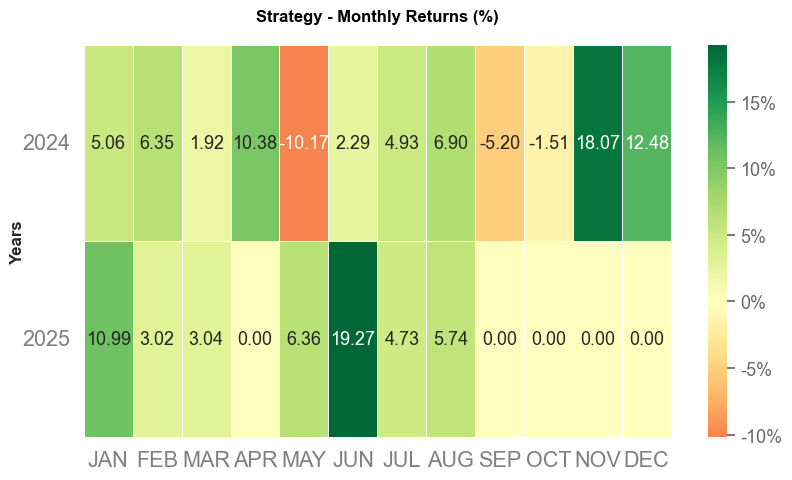

In [276]:
df_trades2.index = pd.to_datetime(df_trades2.index)
qs.plots.monthly_heatmap(df_trades2["return"])

In [234]:
df_trades2.nsmallest(20,"daypnl")

,daypnl,return
date,,
2024-12-23,-2060.000000,-0.041200
2025-01-30,-2016.904762,-0.040338
2024-02-01,-1896.000000,-0.037920
2024-05-02,-1521.369048,-0.030427
2024-11-22,-1378.886447,-0.027578
2024-06-13,-1338.750000,-0.026775
2024-04-01,-1318.809524,-0.026376
2024-03-15,-1235.000000,-0.024700
2024-01-19,-1220.833333,-0.024417


In [36]:
df_trades2.nlargest(20,"daypnl")

,daypnl,return
date,,
2025-05-27,3412.390351,0.034124
2025-01-03,2876.190476,0.028762
2024-11-08,2852.916667,0.028529
2025-08-04,2849.909436,0.028499
2025-01-17,2848.500000,0.028485
2024-02-02,2763.690476,0.027637
2024-07-10,2626.666667,0.026267
2024-08-13,2618.750000,0.026187
2024-07-12,2602.500000,0.026025


In [254]:
# CALL ITM
total_call_itm_pnl = df_trades.loc[(df_trades["sell_type"] == "ITM") & (df_trades["opt_type"] == "C"), "daypnl"].sum()
print("CALL ITM:", total_call_itm_pnl)

# CALL ATM
total_call_atm_pnl = df_trades.loc[(df_trades["sell_type"] == "ATM") & (df_trades["opt_type"] == "C"), "daypnl"].sum()
print("CALL ATM:", total_call_atm_pnl)

# PUT ITM
total_put_itm_pnl = df_trades.loc[(df_trades["sell_type"] == "ITM") & (df_trades["opt_type"] == "P"), "daypnl"].sum()
print("PUT ITM:", total_put_itm_pnl)

# PUT ATM
total_put_atm_pnl = df_trades.loc[(df_trades["sell_type"] == "ATM") & (df_trades["opt_type"] == "P"), "daypnl"].sum()
print("PUT ATM:", total_put_atm_pnl)


total_call_pnl = df_trades.loc[df_trades["opt_type"] == "C", "daypnl"].sum()
print("CALL",total_call_pnl)
total_put_pnl = df_trades.loc[df_trades["opt_type"] == "P", "daypnl"].sum()
print("PUT" , total_put_pnl)

CALL ITM: 12417.094774673376
CALL ATM: 0.0
PUT ITM: 14559.711643884672
PUT ATM: 0.0
CALL 12417.094774673376
PUT 14559.711643884672


                           Strategy
-------------------------  ----------
Start Period               2024-01-02
End Period                 2025-08-06
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          165.92%
CAGR﹪                     52.73%

Sharpe                     2.35
Prob. Sharpe Ratio         99.58%
Smart Sharpe               2.22
Sortino                    3.92
Smart Sortino              3.71
Sortino/√2                 2.77
Smart Sortino/√2           2.62
Omega                      1.45

Max Drawdown               -16.61%
Longest DD Days            109
Volatility (ann.)          37.33%
Calmar                     3.18
Skew                       0.25
Kurtosis                   -0.13

Expected Daily %           0.32%
Expected Monthly %         5.28%
Expected Yearly %          63.07%
Kelly Criterion            17.42%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.52%
Expected Shortfall (cVaR)  -3.52%

Max Consecutive Wins  

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-08-20,2024-11-04,2024-11-15,88,-16.605068,-16.288861
2,2024-04-26,2024-07-02,2024-08-12,109,-12.865659,-12.758608
3,2024-01-24,2024-02-21,2024-02-28,36,-8.513482,-7.642177
4,2025-01-24,2025-02-19,2025-02-24,32,-8.210133,-7.486523
5,2024-11-22,2024-12-05,2024-12-12,21,-6.742637,-5.183584


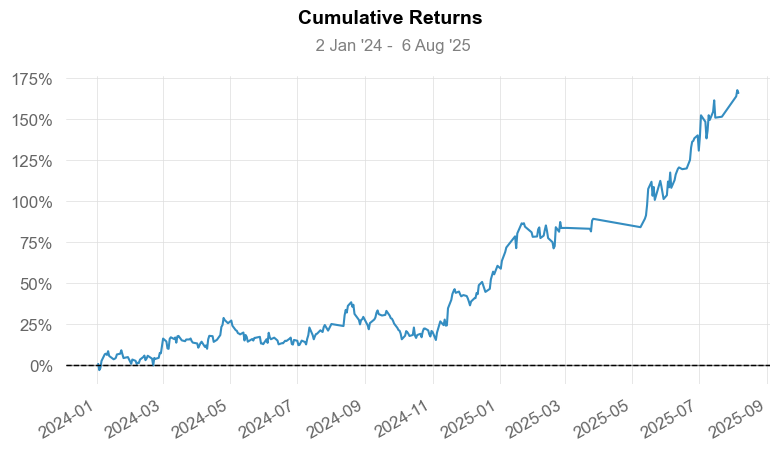

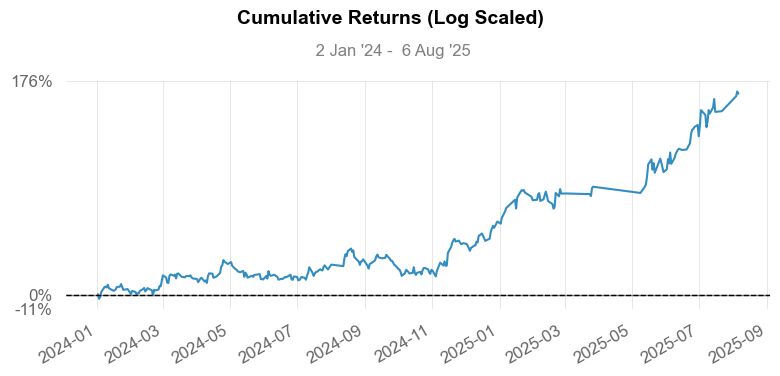

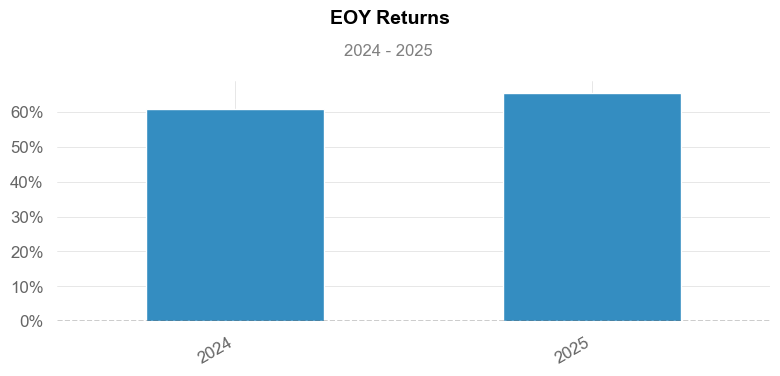

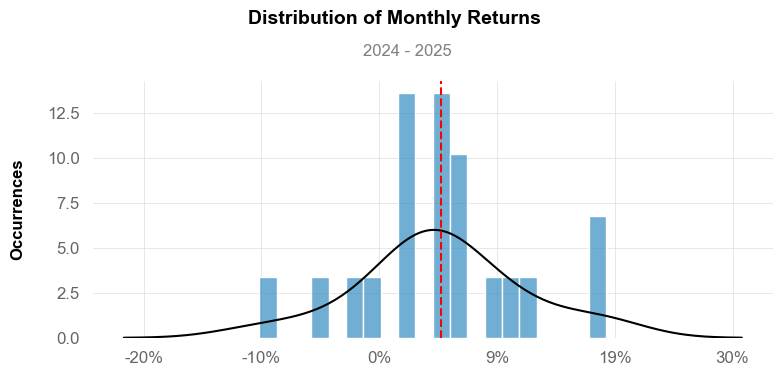

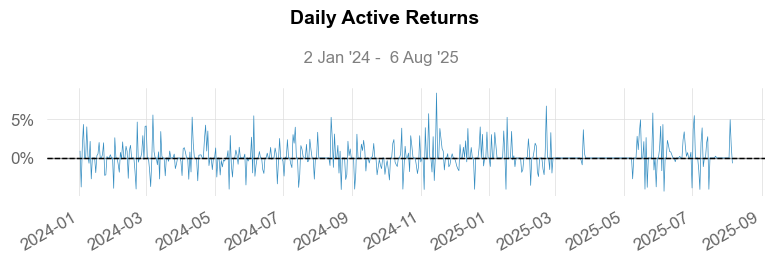

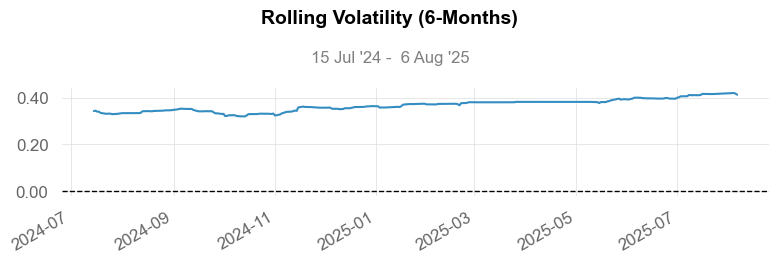

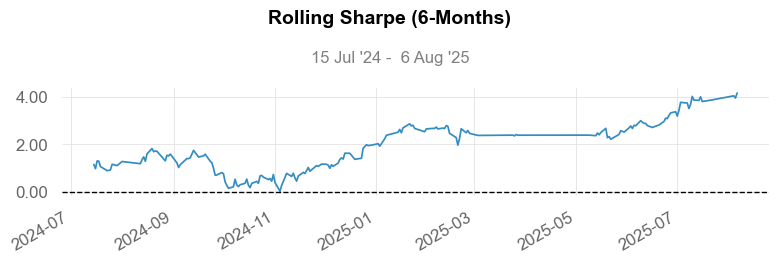

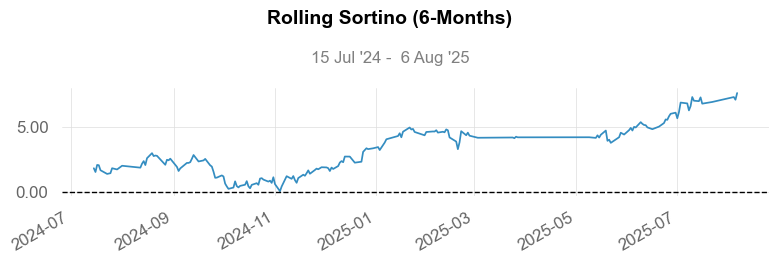

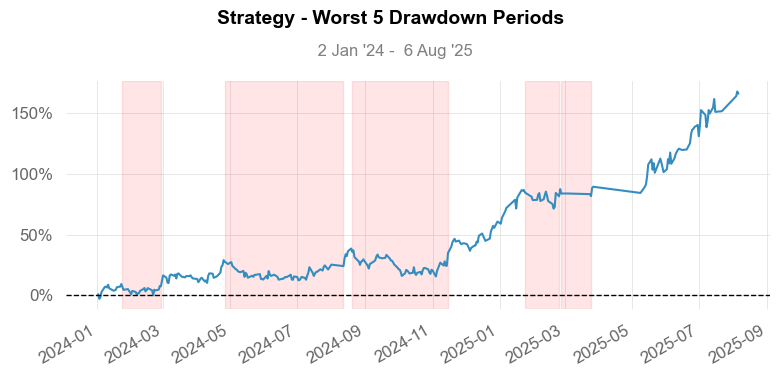

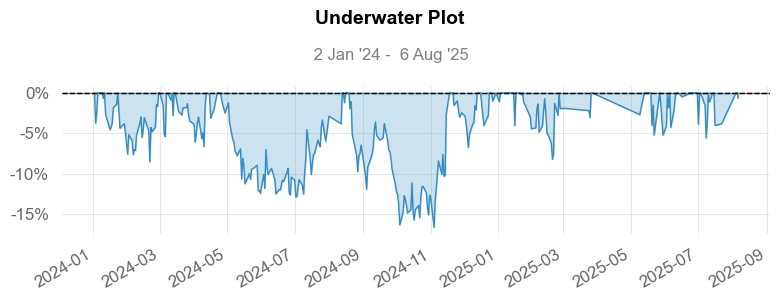

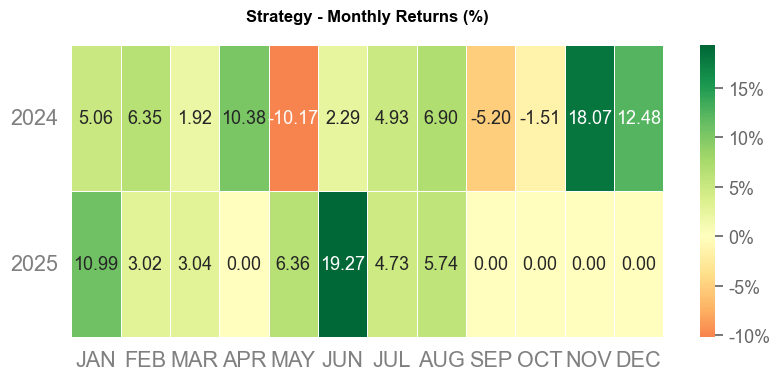

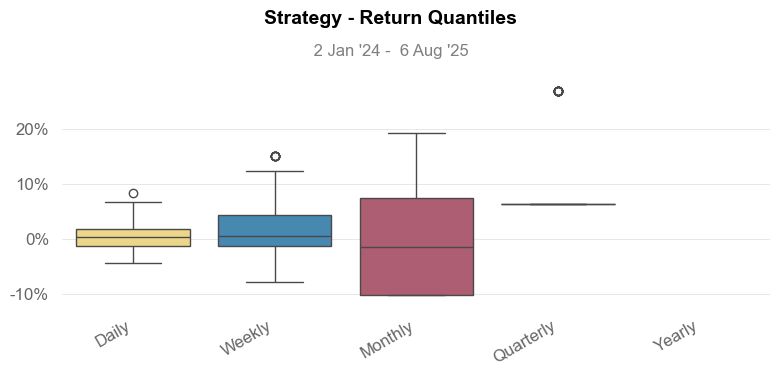

In [277]:
qs.reports.full(df_trades2["return"])